### Ağ Güvenliği Dersi -- Derin Öğrenme Tabanlı Phising URL Tespiti Projesi
* Şahin Emre ASLAN - **S210110115**
* İshak Berke Yaman - **G181210104**


# Gereksinimler - Kütüphane - Çalışma Ortamının Ayarlanması
  Gerekli olan kütüphanelerin import edilmesi, Paralel eğitim gerçekleştirebilmek için CUDA çekirdeğinin kontrolü


In [6]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# VeriSeti Önişleme - Format Dönüşümleri vs.


*   VeriSeti Önişleme
  
  Bu aşamada elde edilen verinin incelenemesi, balans olup/olmama durumu ve nümerikleştirilmesi gerçekleştirilmiştir.
*   Train - Test Kümelerinin Ayrılması

  %66.6 train ve %33.3 test kümesi olacak şekilde veri seti ikiye bölünmüştür.
* Normalizasyon
  Modeli verilen girdilere normalizasyon uygulanmıştır.

* Verisetinin Torch Tensörlerine Uygun Hale Getirilmesi



## VeriSeti Önişleme

In [7]:
df = pd.read_csv("/content/dataset_phishing.csv")
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


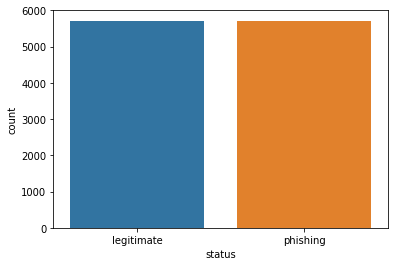

In [8]:
sns.countplot(x = 'status', data=df)

In [9]:
df = df.drop('url', axis=1)

In [10]:
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [11]:
df['status'] = df['status'].astype('category')
encode_map = {
    'phishing': 1,
    'legitimate': 0
}

df['status'].replace(encode_map, inplace=True)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,0


In [12]:
X = df.iloc[:, 0:-1]#Girdilerin Alınması(87 tane sonucu etiketleyen değerlerinin)
y = df.iloc[:, -1]#Çıktıların(Phising 1 - legitimate 0) Alınması

## Train ve Test Kümelerinin Ayrılması

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

## Normalizasyon (0-1)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Verilerin Torch Tensörlerine Uygun Hale Getirilmesi

In [15]:
X.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,0,...,0,0,1,0,45,-1,0,1,1,4
1,77,23,1,1,0,0,0,0,0,0,...,0,1,0,0,77,5767,0,0,1,2
2,126,50,1,4,1,0,1,2,0,3,...,0,1,0,0,14,4004,5828815,0,1,0
3,18,11,0,2,0,0,0,0,0,0,...,0,1,0,0,62,-1,107721,0,0,3
4,55,15,0,2,2,0,0,0,0,0,...,0,0,1,0,224,8175,8725,0,0,6


In [16]:
y.head(10)

0    0
1    1
2    1
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: status, dtype: int64

In [21]:
X.head(10)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,0,...,0,0,1,0,45,-1,0,1,1,4
1,77,23,1,1,0,0,0,0,0,0,...,0,1,0,0,77,5767,0,0,1,2
2,126,50,1,4,1,0,1,2,0,3,...,0,1,0,0,14,4004,5828815,0,1,0
3,18,11,0,2,0,0,0,0,0,0,...,0,1,0,0,62,-1,107721,0,0,3
4,55,15,0,2,2,0,0,0,0,0,...,0,0,1,0,224,8175,8725,0,0,6
5,32,24,0,3,1,0,0,0,0,0,...,0,1,1,1,0,-1,0,0,1,0
6,19,12,0,2,0,0,0,0,0,0,...,0,0,1,0,170,7529,0,0,0,1
7,81,27,1,2,0,0,0,0,0,0,...,0,1,0,0,76,5767,0,0,1,2
8,42,34,0,2,0,0,0,0,0,0,...,0,1,1,0,371,7298,0,0,0,5
9,104,10,0,1,10,0,0,0,0,0,...,0,1,0,0,128,9368,6774,0,0,5


In [22]:
type(X_train)

numpy.ndarray

In [23]:
type(y_train)

numpy.ndarray

In [19]:
y_train = y_train.to_numpy()

In [20]:
type(y_train)

numpy.ndarray

In [24]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [25]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

#Modelin Eğitilmesi
Bu aşama model için hiperparametre seçimi, modelin inşa edilmesi ve eğitim aşamalarından oluşmaktadır.





## Hiperparametre Seçimi

In [119]:
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [120]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Modelin İnşa Edilmesi

In [123]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(87, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [125]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=87, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [126]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [127]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.41966 | Acc: 81.833
Epoch 002: | Loss: 0.19479 | Acc: 93.400
Epoch 003: | Loss: 0.14424 | Acc: 94.667
Epoch 004: | Loss: 0.12389 | Acc: 95.467
Epoch 005: | Loss: 0.11052 | Acc: 95.767
Epoch 006: | Loss: 0.10108 | Acc: 96.433
Epoch 007: | Loss: 0.09292 | Acc: 96.633
Epoch 008: | Loss: 0.08555 | Acc: 97.033
Epoch 009: | Loss: 0.07729 | Acc: 97.367
Epoch 010: | Loss: 0.07505 | Acc: 97.400
Epoch 011: | Loss: 0.06535 | Acc: 97.867
Epoch 012: | Loss: 0.06007 | Acc: 97.867
Epoch 013: | Loss: 0.05646 | Acc: 98.133
Epoch 014: | Loss: 0.05265 | Acc: 98.067
Epoch 015: | Loss: 0.04867 | Acc: 98.400
Epoch 016: | Loss: 0.04564 | Acc: 98.367
Epoch 017: | Loss: 0.04244 | Acc: 98.533
Epoch 018: | Loss: 0.03986 | Acc: 98.533
Epoch 019: | Loss: 0.03708 | Acc: 98.800
Epoch 020: | Loss: 0.03502 | Acc: 98.867
Epoch 021: | Loss: 0.03053 | Acc: 99.033
Epoch 022: | Loss: 0.02907 | Acc: 99.233
Epoch 023: | Loss: 0.02544 | Acc: 99.300
Epoch 024: | Loss: 0.02767 | Acc: 98.933
Epoch 025: | Los

# Modelin Başarımının Değerlenidirilmesi

In [129]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [131]:
confusion_matrix(y_test, y_pred_list)

array([[1810,   85],
       [  76, 1801]])

In [132]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1895
           1       0.95      0.96      0.96      1877

    accuracy                           0.96      3772
   macro avg       0.96      0.96      0.96      3772
weighted avg       0.96      0.96      0.96      3772

